## Differentiable Inverse Rendering for BRDF map minification with SlangTorch

In this demo, we will show how one can use BRDFs defined in a shading languages - Slang - together with PyTorch and differentiable Slang for creating appearance-preserving minified BRDF maps.

We will look here at a common and yet surprisingly difficult task in rendering - BRDF minification.
When naively downsampling all BRDF properties, the appearance changes.
Many analytical and approximate models were proposed for common BRDFs, but often operate under fixed assumptions.
We can use differentiable rendering instead to compute properties that match the appearance as close as possible within the model.


### Preliminaries

In the first step, load Python libraries and the textures we will operate on.
For the textures, use only a crop for better display of details in the notebook.

In [1]:
%pip install slangtorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import torch
import slangtorch
import random

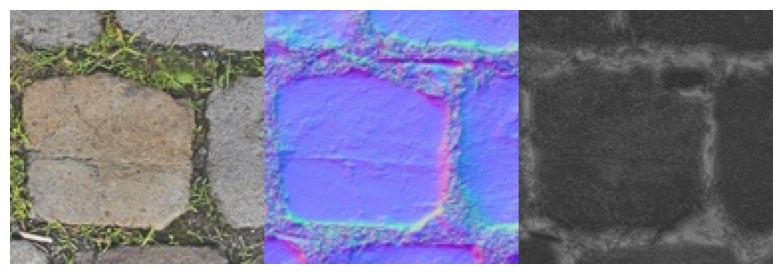

In [10]:
img = cv2.imread(R"diffuse.jpg")[64:64+128,64:64+128,[2,1,0]]/255
normal = cv2.imread(R"normal.jpg")[64:64+128,64:64+128,[2,1,0]]/255
roughness = cv2.imread(R"roughness.jpg")[64:64+128,64:64+128,[2,1,0]]/255

# Square roughness to show more specular highlights for a better visualization.
roughness *= roughness

plt.rcParams['figure.figsize'] = (10, 3.3)
plt.imshow(np.hstack((img, normal, roughness)))
plt.axis("off")
plt.show()

### Forward rendering

We have our data loaded and can proceed to render it using Slang.
Slang is a shading language where one programs in a convenient "traditional" SIMT-fashion and can reuse existing rendering codebases, but we can also easily interface with CUDA and PyTorch, which we will do here for easy interaction in Python.

1. Load a SlangTorch kernel.
2. Create SlangTorch input buffer with BRDF properties and in this case, desired lighting vector and view direction.
3. Run the CUDA kernel generated by SlangTorch.
4. Fetch the results to the CPU and display.

In [11]:
!pwd

/content


/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


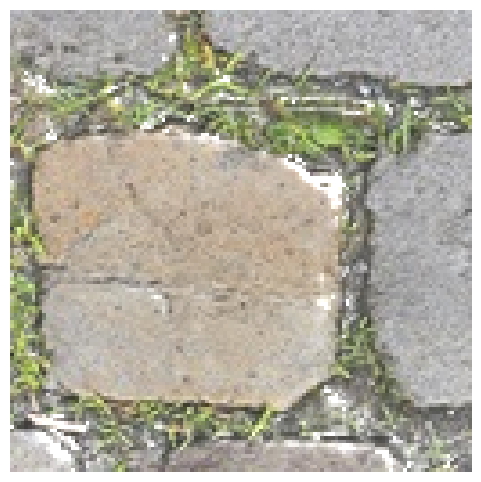

In [26]:
def display(x):
    return np.clip(2*x, 0, 1)

def grid_size(shape, threads_dim = 16):
    return ((shape[0] + threads_dim - 1)//threads_dim, (shape[1] + threads_dim - 1)//threads_dim, 1)

m = slangtorch.loadModule("lightkernel.slang")
# Concatenate all the BRDF inputs as a 9-channel tensor.
brdf_input_torch = torch.tensor(np.concatenate((img, normal, roughness[...,[0]]), axis=-1), dtype=torch.float32).cuda().contiguous()
full_res_brdf = brdf_input_torch.clone()

original_shape = (brdf_input_torch.shape[0], brdf_input_torch.shape[1])
output_shape = (brdf_input_torch.shape[0], brdf_input_torch.shape[1], 3)

block_size = (16, 16, 1)
grid_size = grid_size(original_shape)

light_vector = (0.2, -0.2, 0.6)
view_vector = (0.0, 0.0, 1.0)
input_params = (*light_vector, *view_vector)
lighting_from_full_res_brdf = torch.zeros(output_shape).cuda()
m.brdf(input=full_res_brdf,
       output=lighting_from_full_res_brdf,
       input_params=input_params).launchRaw(blockSize=block_size, gridSize=grid_size)
plt.rcParams['figure.figsize'] = (6, 6)
plt.imshow(display(lighting_from_full_res_brdf.cpu()))
plt.axis("off")
plt.show()

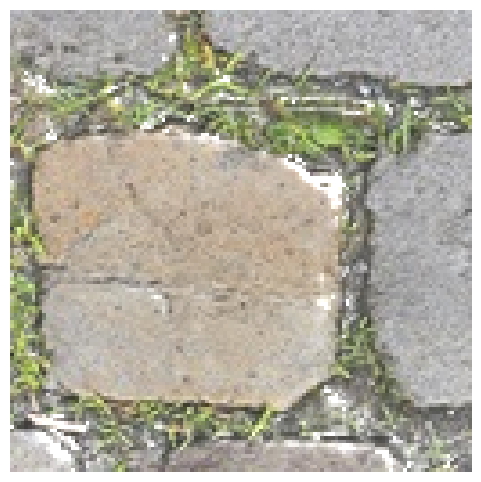

In [27]:
kernel = torch.tensor([
    [0., 0., 0.],
    [0., 1., 0.],
    [0., 0., 0.]
]).cuda()
input_params = (brdf_input_torch.shape[0], brdf_input_torch.shape[1], kernel.shape[0])
lighting_from_full_res_brdf_2 = torch.zeros(output_shape).cuda()
m.convolve(input=lighting_from_full_res_brdf,
       output=lighting_from_full_res_brdf_2,
        kernel = kernel,
       input_params=input_params).launchRaw(blockSize=block_size, gridSize=grid_size)


plt.rcParams['figure.figsize'] = (6, 6)
plt.imshow(display(lighting_from_full_res_brdf.cpu()))
plt.axis("off")
plt.show()

### Inverse rendering - computing BRDF properties gradients from SlangTorch

We can use now the newly added differentiable programming options in SlangTorch to generate gradients w.r.t some loss function.
We will look here at rendering of a downsampled BRDF map at the native resolution.
Shader kernel performs downsampling and we can display:
1. The original image, rendered with both BRDF and the rendering at the same, native resolution.
2. Image rendered with BRDF at the half resolution, bilinearly upsampled in the shader to render at the native resolution.
3. Gradients w.r.t. some BRDF properties - in this case, diffuse - based on the appearance (rendering) difference squared.

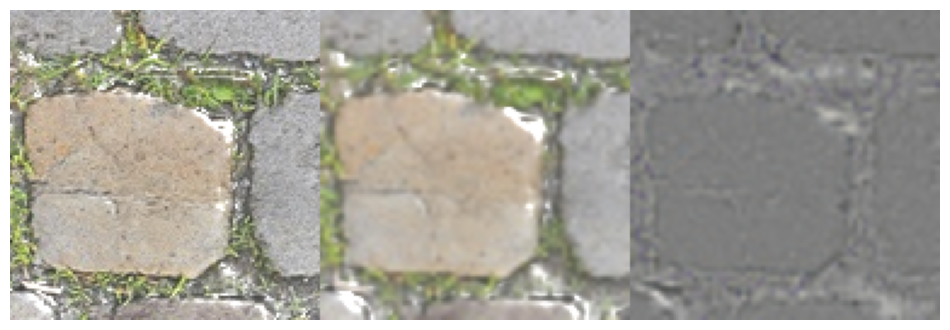

In [6]:
full_res_brdf = brdf_input_torch.clone()
# Resize BRDF map to half resolution.
half_res_brdf = torch.tensor(cv2.resize(brdf_input_torch.cpu().numpy(), None, fx=0.5, fy=0.5), dtype=torch.float32).cuda()

# Initialize outputs.
lighting_from_full_res_brdf = torch.zeros(output_shape).cuda()
lighting_from_half_res_brdf = torch.zeros(output_shape).cuda()
gradient_output = torch.zeros_like(half_res_brdf).cuda()
loss_output = torch.zeros((original_shape[0], original_shape[1], 1)).cuda()
output_grad = torch.ones_like(loss_output).cuda()

# Reference and the lighting from half-res resized BRDF.
m.brdf(input=full_res_brdf, output=lighting_from_full_res_brdf, input_params=input_params).launchRaw(blockSize=block_size, gridSize=grid_size)
m.brdf(input=half_res_brdf, output=lighting_from_half_res_brdf, input_params=input_params).launchRaw(blockSize=block_size, gridSize=grid_size)

# Backward gradient pass.
m.brdf_loss.bwd(input=(half_res_brdf, gradient_output), output=(loss_output, output_grad), reference=lighting_from_full_res_brdf, input_params=input_params).launchRaw(blockSize=block_size, gridSize=grid_size)

# We want to display it together with outputs, resize.
gradient_resized = cv2.resize(gradient_output.cpu().numpy(), None, fx=2, fy=2)
plt.rcParams['figure.figsize'] = (12, 12)
plt.imshow(display(np.hstack((lighting_from_full_res_brdf.cpu(), lighting_from_half_res_brdf.cpu(), 0.25 + 0.5*gradient_resized[...,0:3]))))
plt.axis("off")
plt.show()

### Appearance-based BRDF property optimization

Now that we can compute gradients of the BRDF properties, we can do the following:
1. Generate some random light direction vector.
2. Render the reference full resolution image and the upsampled properties image using this same vector.
3. Compute the loss as the squared difference of those renderings.
4. Perform stochastic gradient descent on the BRDF properties until convergence.

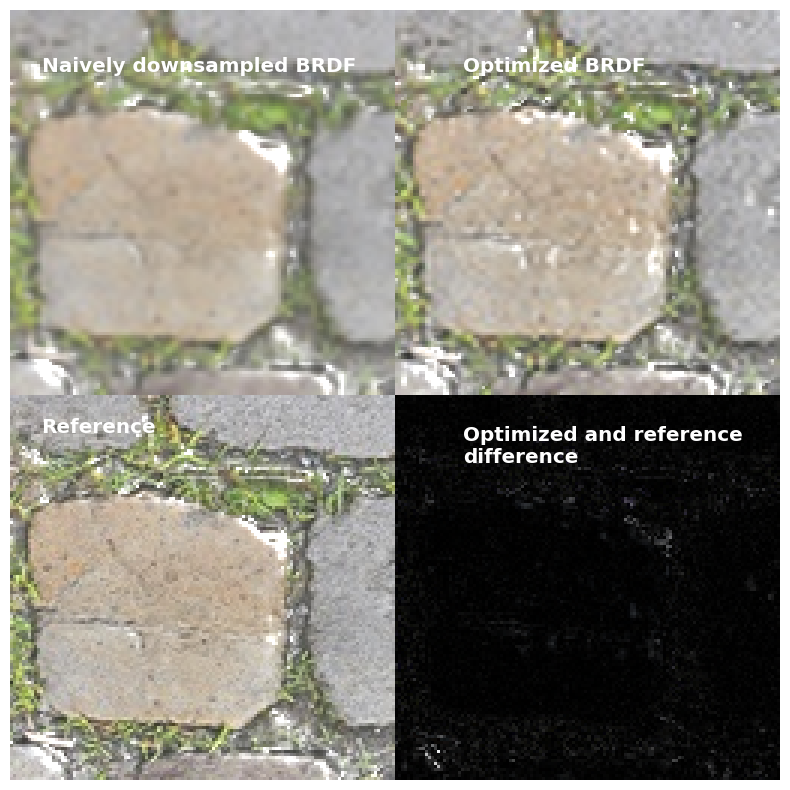

In [7]:
def random_hemi_vector():
    a, b, c = random.normalvariate(0, 1), random.normalvariate(0, 1), random.normalvariate(0, 1)
    l = (np.sqrt(a**2 + b**2 + c**2) + 0.0001)
    a, b, c = a/l, b/l, c/l
    c = abs(c)
    return (a/l, b/l, c/l)

# Initialize inputs and outputs.
full_res_brdf = brdf_input_torch.clone()
lighting_from_full_res_brdf = torch.zeros(output_shape).cuda()
half_res_brdf = torch.tensor(cv2.resize(brdf_input_torch.cpu().numpy(), None, fx=0.5, fy=0.5), dtype=torch.float32).cuda()
half_res_brdf_before_optim = half_res_brdf.clone()

for i in range(10000):
    L = random_hemi_vector()
    V = (0.0, 0.0, 1.0)
    input_params = (*L, *V)
    loss_output = torch.zeros((original_shape[0], original_shape[1], 1)).cuda()
    output_grad = torch.ones_like(loss_output).cuda()
    m.brdf(input=full_res_brdf,
           output=lighting_from_full_res_brdf,
           input_params=input_params).launchRaw(blockSize=block_size, gridSize=grid_size)

    m.brdf_loss.bwd(input=(half_res_brdf, gradient_output),
                    output=(loss_output, output_grad),
                    reference=lighting_from_full_res_brdf,
                    input_params=input_params).launchRaw(blockSize=block_size, gridSize=grid_size)
    # Clip gradients and prevent.
    gradient_output = torch.nan_to_num(gradient_output, 0.0)
    gradient_output = torch.clamp(gradient_output, -1.0, 1.0)
    half_res_brdf = torch.clip(half_res_brdf - 0.001 * gradient_output, 0.0001, 1.0)

# Initialize the output buffers and final display parameters.
input_params = (*light_vector, *view_vector)
lighting_from_full_res_brdf = torch.zeros(output_shape).cuda()
lighting_from_half_res_brdf = torch.zeros(output_shape).cuda()
lighting_before_optim = torch.zeros(output_shape).cuda()

# Run the lighting passes.
m.brdf(input=full_res_brdf,
       output=lighting_from_full_res_brdf,
       input_params=input_params).launchRaw(blockSize=block_size, gridSize=grid_size)

m.brdf(input=half_res_brdf,
       output=lighting_from_half_res_brdf,
       input_params=input_params).launchRaw(blockSize=block_size, gridSize=grid_size)

m.brdf(input=half_res_brdf_before_optim,
       output=lighting_before_optim,
       input_params=input_params).launchRaw(blockSize=block_size, gridSize=grid_size)

# Plotting.
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(display((np.block([[[lighting_before_optim.cpu().numpy()],
                               [lighting_from_half_res_brdf.cpu().numpy()]],
                              [[lighting_from_full_res_brdf.cpu().numpy()],
                               [0.5*np.abs((lighting_from_full_res_brdf-lighting_from_half_res_brdf).cpu().numpy())]]]))))
plt.text(10, 20, "Naively downsampled BRDF", fontsize='x-large', color='white', fontweight='bold')
plt.text(150, 20, "Optimized BRDF", fontsize='x-large', color='white', fontweight='bold')
plt.text(10, 140, "Reference", fontsize='x-large', color='white', fontweight='bold')
plt.text(150, 150, "Optimized and reference\ndifference", fontsize='x-large', color='white', fontweight='bold')
plt.axis("off")
plt.show()

We can preview the optimized BRDF properties and look at the behavior of the optimization process.

The behavior matches some well-known analytical approximate models, such as Toksvig mapping - roughness increases in areas with a large normal map variation.
On top of it, the optimization process *sharpens* the BRDF maps to compensate for upsampling with a bilinear kernel.
Interestingly, this is a common practice of video game artists (sharpening the mip-maps).

Both of those behaviors are automatically inferred from the data and gradients of the BRDF function and unlike analytical models created for specific BRDFs, can work as drop-in for many BRDFs or even BRDF mixtures.

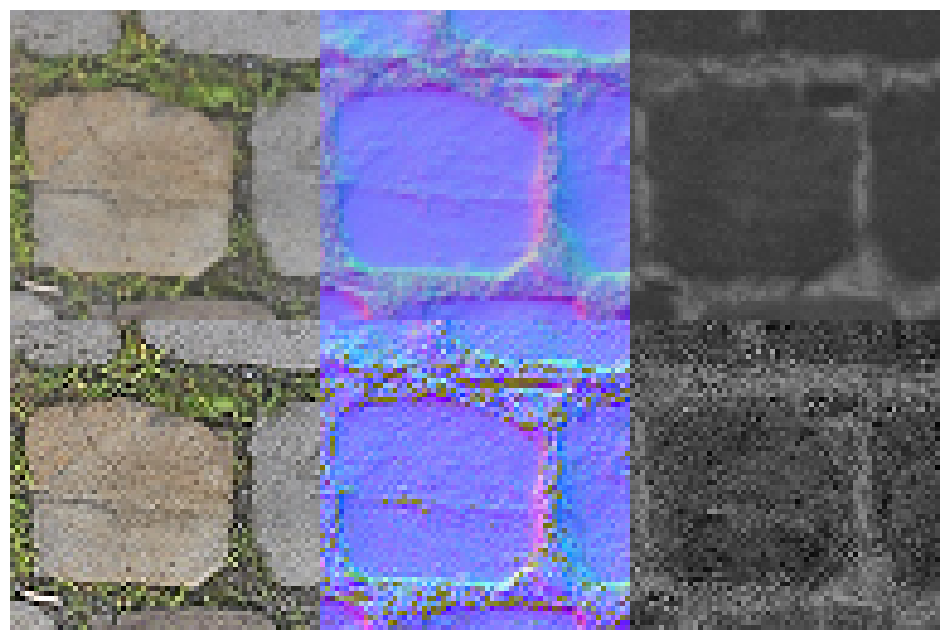

In [8]:
plt.rcParams['figure.figsize'] = (12, 12)

a, b, c = (np.vstack((half_res_brdf_before_optim.cpu()[..., 0:3], half_res_brdf.cpu()[..., 0:3])),
           np.vstack((half_res_brdf_before_optim.cpu()[..., 3:6], half_res_brdf.cpu()[..., 3:6])),
           np.vstack((half_res_brdf_before_optim.cpu()[..., [6,6,6]], half_res_brdf.cpu()[..., [6,6,6]])))
plt.imshow(np.hstack((a,b,c)))
plt.axis("off")
plt.show()